PAN VERIFICATION

STEP 1 : Importing all the necessary Librarires for building the Model

In [1]:
import os
import shutil
import random
import pickle
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

STEP 2 : Gather a labeled dataset consisting of real and fake Aadhaar card images

In [2]:
dataset_path = r"C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Dataset"
real_images_folder = os.path.join(dataset_path, "Real")
fake_images_folder = os.path.join(dataset_path, "Fake")


STEP 3 : Data Preprocessing: Convert the images to a consistent format and resize them

In [3]:
target_size = (224, 224)  # Specify the desired target size for the images

def load_and_preprocess_image(image_path, target_size):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image = np.array(image) / 255.0  # Normalize pixel values to the range of [0, 1]
    return image

STEP 4 : Splitting the Dataset: Split the dataset into training and validation sets

In [4]:
train_real_images, val_real_images = train_test_split(os.listdir(real_images_folder), test_size=0.2, random_state=42)
train_fake_images, val_fake_images = train_test_split(os.listdir(fake_images_folder), test_size=0.2, random_state=42)

STEP 5 : Feature Extraction

In [5]:
def extract_features(image_paths):
    model = VGG16(weights='imagenet', include_top=False, pooling='avg')
    features = []
    for image_path in image_paths:
        image = load_and_preprocess_image(os.path.join(dataset_path, image_path), target_size)
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        features.append(model.predict(image))
    return np.array(features)

train_real_features = extract_features([os.path.join(real_images_folder, img) for img in train_real_images])
val_real_features = extract_features([os.path.join(real_images_folder, img) for img in val_real_images])
train_fake_features = extract_features([os.path.join(fake_images_folder, img) for img in train_fake_images])
val_fake_features = extract_features([os.path.join(fake_images_folder, img) for img in val_fake_images])

train_features = np.concatenate((train_real_features, train_fake_features))
val_features = np.concatenate((val_real_features, val_fake_features))

1/1 [==============================] - 0s 402ms/step


STEP 6 : Model Training

In [6]:
train_labels = np.array([1] * len(train_real_features) + [0] * len(train_fake_features))
val_labels = np.array([1] * len(val_real_features) + [0] * len(val_fake_features))

model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_features, train_labels, batch_size=32, epochs=50, validation_data=(val_features, val_labels))

Epoch 1/50
3/3 [==============================] - 4s 206ms/step - loss: 0.7134 - accuracy: 0.4074 - val_loss: 0.6419 - val_accuracy: 0.7143
Epoch 2/50
3/3 [==============================] - 0s 113ms/step - loss: 0.6192 - accuracy: 0.7284 - val_loss: 0.5996 - val_accuracy: 0.7143
Epoch 3/50
3/3 [==============================] - 0s 39ms/step - loss: 0.5936 - accuracy: 0.7284 - val_loss: 0.5940 - val_accuracy: 0.7143
Epoch 4/50
3/3 [==============================] - 0s 31ms/step - loss: 0.5796 - accuracy: 0.7284 - val_loss: 0.5867 - val_accuracy: 0.7143
Epoch 5/50
3/3 [==============================] - 0s 28ms/step - loss: 0.5739 - accuracy: 0.7284 - val_loss: 0.5741 - val_accuracy: 0.7143
Epoch 6/50
3/3 [==============================] - 0s 29ms/step - loss: 0.5623 - accuracy: 0.7284 - val_loss: 0.5606 - val_accuracy: 0.7143
Epoch 7/50
3/3 [==============================] - 0s 30ms/step - loss: 0.5528 - accuracy: 0.7284 - val_loss: 0.5487 - val_accuracy: 0.7143
Epoch 8/50
3/3 [=========

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
test_labels = np.array([1] * len(val_real_features) + [0] * len(val_fake_features))

test_predictions = model.predict(val_features)
test_predicted_labels = np.where(test_predictions > 0.5, 1, 0)

test_cm = confusion_matrix(test_labels, test_predicted_labels)
test_accuracy = np.sum(np.diag(test_cm)) / np.sum(test_cm)

print("Test Confusion Matrix:")
print(test_cm)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 133ms/step
Test Confusion Matrix:
[[15  0]
 [ 0  6]]
Test Accuracy: 1.0


Plot the confusion matrix

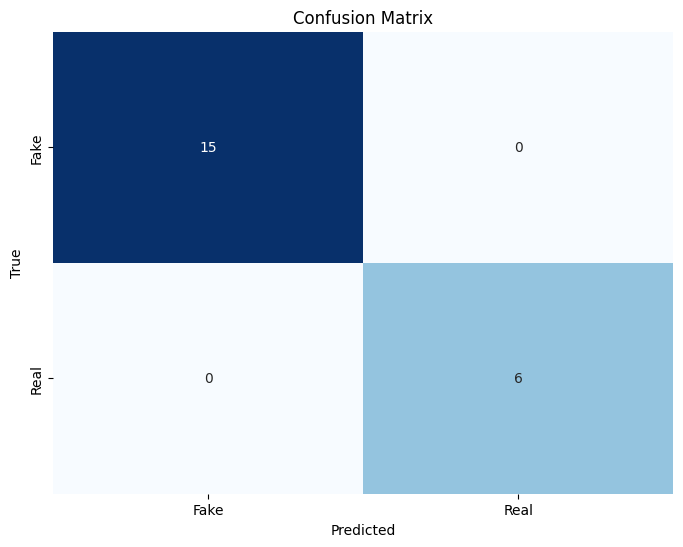

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

STEP 7 - Model Evaluation

In [10]:
test_images_folder = r"C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Testing"  # Update this with the path to your test images folder
test_image_paths = [os.path.join(test_images_folder, img) for img in os.listdir(test_images_folder)]
test_features = extract_features(test_image_paths)

predictions = model.predict(test_features)
predicted_labels = ["Real" if pred > 0.5 else "Fake" for pred in predictions]

for image_path, label in zip(test_image_paths, predicted_labels):
    print(f"{image_path}: {label}")

1/1 [==============================] - 0s 29ms/step
C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Testing\Fake_Pan_18.jpg: Fake
C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Testing\Fake_Pan_19.jpg: Fake
C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Testing\Fake_Pan_20.jpg: Fake
C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Testing\Fake_Pan_21.jpg: Fake
C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Testing\Fake_Pan_22.jpg: Fake
C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Testing\Fake_Pan_23.jpg: Fake
C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Testing\Real_Pan_1.jpg: Real
C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Testing\Real_Pan_2.jpg: Real
C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Testing\Real_Pan_3.jpg: Real
C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Testing\Real_Pan_4.jpg: Real


STEP 8 - Deploying the model as .pkl, .h5, .json

In [12]:
import pickle
import h5py
import os
import shutil

# Assuming you have trained a model and stored it in the 'model' variable

# Save model as HDF5 file
h5_filename = 'model.h5'
model.save(h5_filename)

# Save model as pickle file
pickle_filename = 'model.pkl'
with open(pickle_filename, 'wb') as f:
    pickle.dump(model, f)

# Specify the folder path to save the model files
folder_path = r'C:\Users\admin\OneDrive\Desktop\Document_verification\Pan\Training\Models_Trained'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Move the saved model files to the folder
h5_filepath = os.path.join(folder_path, h5_filename)
pickle_filepath = os.path.join(folder_path, pickle_filename)
shutil.move(h5_filename, h5_filepath)
shutil.move(pickle_filename, pickle_filepath)


'C:\\Users\\admin\\OneDrive\\Desktop\\Document_verification\\Pan\\Training\\Models_Trained\\model.pkl'